# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: CodeChallenge: The mystery of the missing 7
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [64]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [65]:
# import dataset (comes with colab!)
# data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# import dataset from torchvision
import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

train_data = mnist_train.data
train_labels = mnist_train.targets
test_data = mnist_test.data
test_labels = mnist_test.targets

# reshape data to 2D tensor
train_data = train_data.reshape(-1, 28*28).float()
test_data = test_data.reshape(-1, 28*28).float()

labels = torch.cat((train_labels, test_labels), dim=0)
data = torch.cat((train_data, test_data), dim=0)

dataNorm = data / np.max(data.numpy())

labelsPy = labels.numpy()
dataPy = data.numpy()
dataNormPy = dataNorm.numpy()

print(dataNorm.shape)
print(labels.shape)

torch.Size([70000, 784])
torch.Size([70000])


# Remove the 7's

In [66]:
data_no_7 = dataNorm[labels != 7]
data_7 = dataNorm[labels == 7]
labels_no_7 = labels[labels != 7]
labels_7 = labels[labels == 7]

# Check for 7's in the training labels
print("Number of 7's in training labels:", (labels_7 == 7).sum().item())

Number of 7's in training labels: 7293


# Create train/test groups using DataLoader

In [67]:
# Step 1: convert to tensor
data_no_7   = data_no_7.clone().detach().float()
data_7      = data_7.clone().detach().float()
labels_no_7 = labels_no_7.clone().detach().long()
labels_7    = labels_7.clone().detach().long()

# Step 2: use scikitlearn to split the data
# There is no need to do this, as the training data will be the no_7 data
# and the test data will be the 7 data

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(data_no_7,labels_no_7)
test_data  = TensorDataset(data_7)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [68]:
# create a class for the model
def createTheMNISTNet(layers, units):

  class mnistNet(nn.Module):
    def __init__(self,layers, units):
      super().__init__()

      # Create dictionary of layers
      self.layers = nn.ModuleDict()
      self.nlayers = layers

      ### input layer
      self.layers['input'] = nn.Linear(784,units)
      
      # ### hidden layer
      for i in range(layers):
        self.layers[f'hidden{i}'] = nn.Linear(units,units)

      ### output layer
      self.layers['output'] = nn.Linear(units,10)

    # forward pass
    def forward(self,x):
      x = F.relu(self.layers['input'](x))

      for i in range(self.nlayers):
        x = F.relu( self.layers[f'hidden{i}'](x) )

      return torch.log_softmax( self.layers['output'](x),axis=1 )
      
  
  # create the model instance
  net = mnistNet(layers,units)
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  # Adam is so good, that we can't study the problem correctly if we use it
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [69]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(1,50)

X,y = next(iter(train_loader))
print(X.shape)
yHat = net(X)

print(yHat.shape)
print(torch.exp(yHat)) # values are log-probability of each number (0-9)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

torch.Size([32, 784])
torch.Size([32, 10])
tensor([[0.1077, 0.0953, 0.0955, 0.1116, 0.0994, 0.0899, 0.0795, 0.0941, 0.1177,
         0.1095],
        [0.1038, 0.0954, 0.0964, 0.1113, 0.1006, 0.0903, 0.0805, 0.0975, 0.1172,
         0.1070],
        [0.1064, 0.0932, 0.0950, 0.1083, 0.1025, 0.0920, 0.0822, 0.0968, 0.1171,
         0.1067],
        [0.1107, 0.0959, 0.0983, 0.1054, 0.1007, 0.0901, 0.0828, 0.0978, 0.1133,
         0.1049],
        [0.1039, 0.0886, 0.1023, 0.1149, 0.1062, 0.0908, 0.0793, 0.0927, 0.1121,
         0.1092],
        [0.1064, 0.0960, 0.0954, 0.1117, 0.1017, 0.0887, 0.0812, 0.0964, 0.1127,
         0.1097],
        [0.1100, 0.0974, 0.0951, 0.1111, 0.1008, 0.0894, 0.0793, 0.0981, 0.1129,
         0.1059],
        [0.1056, 0.0969, 0.0938, 0.1029, 0.1009, 0.0916, 0.0823, 0.0993, 0.1205,
         0.1063],
        [0.1091, 0.0944, 0.0959, 0.1107, 0.1013, 0.0924, 0.0798, 0.0945, 0.1173,
         0.1045],
        [0.1053, 0.0940, 0.0974, 0.1117, 0.1022, 0.0892, 0.0791, 0

# Create a function that trains the model

In [70]:
# a function that trains the model

def function2trainTheModel(net, layers, units):

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet(layers, units)

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainAcc,losses


# Now we train it

In [71]:
trainAcc,losses = function2trainTheModel(net,2,64)

# We organise the predictions

In [75]:
X = next(iter(test_loader))[0] # extract X,y from test dataloader
with torch.no_grad():
    yHat = net(X)

predicted_labels = torch.argmax(yHat, axis=1)

print(predicted_labels)

# Count the occurrences of each predicted label
range_predictions, predictions = np.unique(predicted_labels, return_counts=True)


tensor([8, 8, 8,  ..., 8, 8, 8])


In [73]:
print(predicted_labels)
print(range_predictions)
print(predictions)

tensor([8, 8, 8,  ..., 8, 8, 8])
[0 3 8 9]
[   1  249 7040    3]


# Now we see the predicted values and we graph it

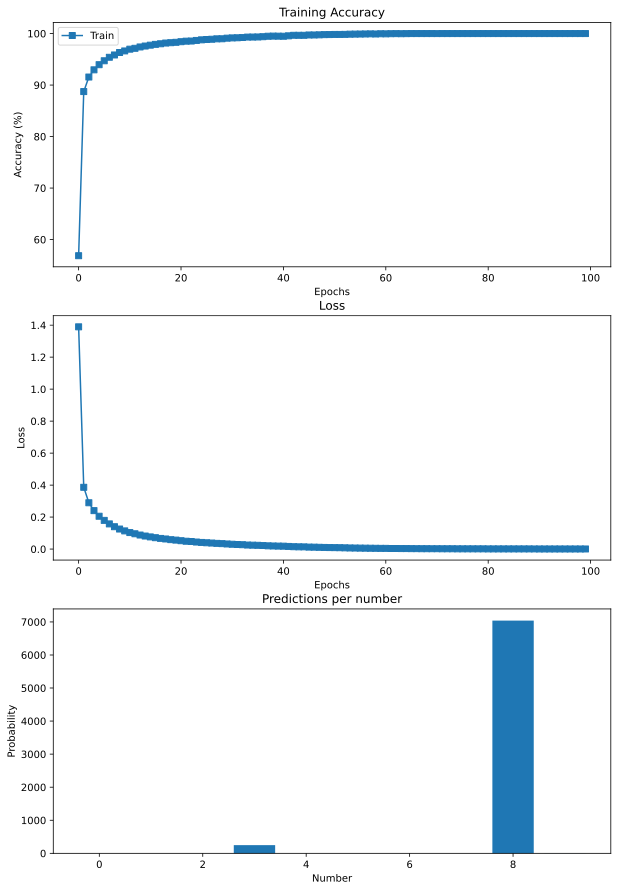

In [74]:
fig,ax = plt.subplots(3,figsize=(10,15))

ax[0].plot(trainAcc,'s-')
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend(['Train','Test'])

ax[1].plot(losses,'s-')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

ax[2].bar(range_predictions,predictions)
ax[2].set_title('Predictions per number')
ax[2].set_xlabel('Number')
ax[2].set_ylabel('Probability')


plt.show()